# Whiting I
This notebook explores a very simple analysis to show the utility of notebooks in general, and some of the features of the JupyterLab environment specifically.

This notebook uses data from DR14 of the [SDSS](https://www.sdss.org/dr14/) survey using the globular cluster Whiting I as a starting point.  See the [finding chart](http://skyserver.sdss.org/dr8/en/tools/chart/navi.asp?ra=30.7367&dec=-3.25319&opt=).

## Before running the notebook, get the data

### Get the catalog

In [19]:
!mkdir -p $HOME/DATA

In [62]:
!if ! [ -f $HOME/DATA/cluster.csv ]; then \
    curl https://lsst-web.ncsa.illinois.edu/~krughoff/data/MyResult_20171010_5.csv -o $HOME/DATA/cluster.csv; fi

This catalog was generated using the following [CasJobs](https://skyserver.sdss.org/CasJobs/SubmitJob.aspx) query:
```sql
SELECT si.ra, si.dec, si.type, si.psfMag_u, si.psfMag_g, si.psfMag_r, si.psfMag_i, si.psfMag_z,
  si.psfMagErr_u, si.psfMagErr_g, si.psfMagErr_r, si.psfMagErr_i, si.psfMagErr_z,
  si.modelMag_u, si.modelMag_g, si.modelMag_r, si.modelMag_i, si.modelMag_z,
  si.modelMagErr_u, si.modelMagErr_g, si.modelMagErr_r, si.modelMagErr_i, si.modelMagErr_z
FROM photoprimary si WHERE
si.ra between 30.7375-0.1 AND 30.7375+0.1 AND
si.dec between -3.2528-0.1 AND -3.2528+0.1
```
### Get an image

This image was identified by using the SDSS [SIAP service](http://cas.sdss.org/dr14/en/help/docs/api.aspx#voservice) -- specifically, by looking through the response from [this URL](http://skyserver.sdss.org/dr14/SkyServerWS/SIAP/getSIAP?POS=30.7375,-3.2528&SIZE=0.001&FORMAT=image/fits).

***Should the SIAP results be giving human-readable output? All I see is raw XML, which is maybe not the best thing to point people to...***

In [22]:
!if ! [ -f $HOME/DATA/frame-r-007778-1-0522.fits ]; then \
    curl -L http://dr14.sdss.org/sas/dr14/eboss/photoObj/frames/301/7778/1/frame-r-007778-1-0522.fits.bz2 \
    -o $HOME/DATA/frame-r-007778-1-0522.fits.bz2; bunzip2 $HOME/DATA/frame-r-007778-1-0522.fits.bz2; fi

## Simple density analysis

Initial imports.  The first import will fail, but be caught.  This is intentional to show the extensible environment.  To run the notebook either delete the boto import, or open a terminal and execute the following commands:
```
$> source /opt/lsst/software/stack/loadLSST.bash
$> pip install --user boto
```

In [25]:
### Why do we need boto? (Is it used?)

try:
    import boto # this will fail on systems that don't have boto
except ModuleNotFoundError:
    print("You can install boto by following the steps above.")
    
import numpy, os
from matplotlib import pylab as plt
plt.rcParams['figure.dpi'] = 120
from scipy.ndimage.filters import gaussian_filter

import astropy.io.fits as fits
from astropy.wcs import WCS

Set some useful variables

In [26]:
ra = 30.7375 # RA of Whiting 1, in degrees
dec = -3.2528 # Dec of Whiting 1, in degrees
radius = 1.2/60 # radius of Whiting 1, in degrees (1.2 arcmin, converted to degrees)

Read in the catalog

In [47]:
home = os.getenv('HOME')
cat = numpy.genfromtxt(os.path.join(home,"DATA/cluster.csv"), names=True, dtype=None, delimiter=',')

# NOTE: to see the names of the columns included in this array, use the following:
# cat.dtype.names

Does the catalog look reasonable? Plot positions of stars on the sky.

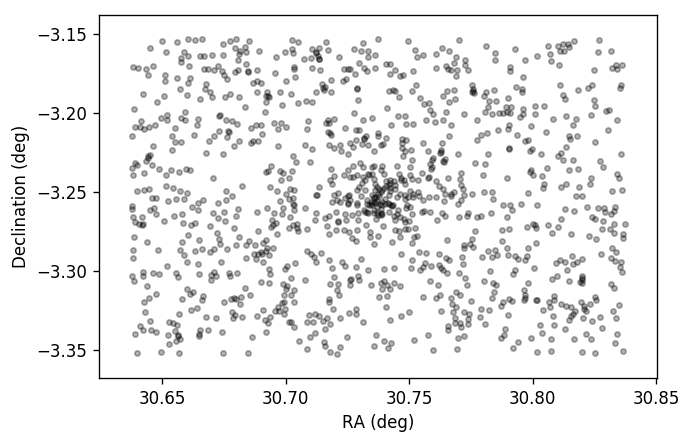

In [29]:
def plot(x, y):
    plt.scatter(x, y, alpha=0.3, s=10, c='black')
    plt.xlabel('RA (deg)')
    plt.ylabel('Declination (deg)')
    plt.show()

plot(cat['ra'], cat['dec'])

Good - there's a cluster of objects at the center.

SDSS gives us a star galaxy separation.  Let's use it!

As outlined [in this description of SDSS morphological parameters](https://www.sdss.org/dr14/algorithms/classify/), objects classified as 'GALAXY' have *type* = 3, and those classified as 'STAR' have *type* = 6.

In [32]:
stars = cat[numpy.where(cat['type']==6)[0]]
galaxies = cat[numpy.where(cat['type']==3)[0]]

Do stars cluster around the position of Whiting 1?

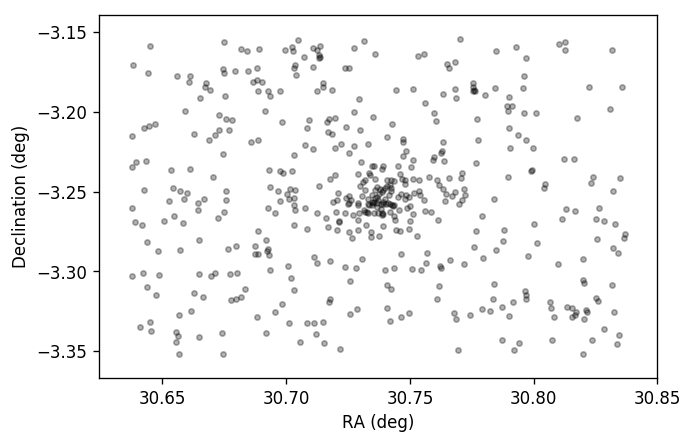

In [34]:
plot(stars['ra'], stars['dec'])

Yes - stars are clustered as expected!

How about galaxies?

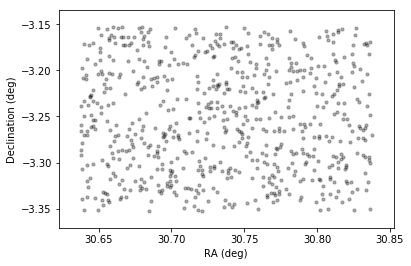

In [10]:
plot(galaxies['ra'], galaxies['dec'])

Galaxies are not clustered, but more or less randomly distributed.

Select cluster members spatially using the central (RA, Dec) of Whiting 1 and the radius, as defined above.

In [35]:
cluster_stars = stars[numpy.where(numpy.hypot(stars['ra']-ra, stars['dec']-dec) < radius)[0]]

Compare spatially selected stars with all stars in a color-magnitude diagram.

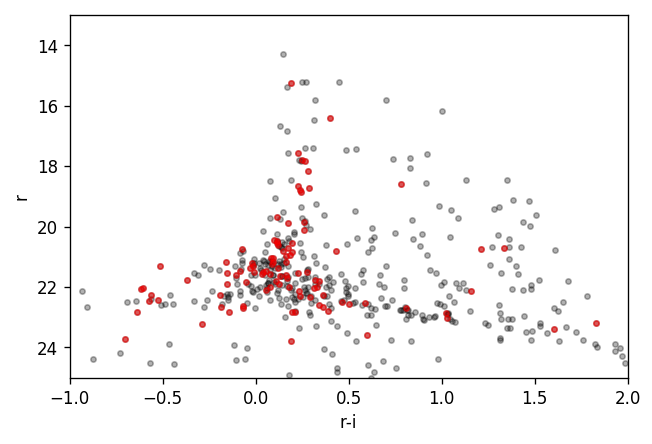

In [71]:
plt.scatter(stars['psfMag_r']-stars['psfMag_i'], stars['psfMag_r'], alpha=0.3, s=10, c='black')
plt.scatter(cluster_stars['psfMag_r']-cluster_stars['psfMag_i'], cluster_stars['psfMag_r'], c='red', alpha=0.5, s=10)

# Uncomment the following line if you'd like to see where galaxies are in the CMD:
#plt.scatter(galaxies['psfMag_r']-galaxies['psfMag_i'], galaxies['psfMag_r'], c='green', alpha=0.3, s=10)

plt.ylim(25, 13)
plt.xlim(-1, 2.)
plt.xlabel('r-i')
plt.ylabel('r')
plt.show()

Make a reasonable cut in `r-i` color space that isolates most of the cluster stars.

In [80]:
rmi = stars['psfMag_r']-stars['psfMag_i']
cluster = stars[numpy.where((rmi>-0.25) & (rmi<0.5))[0]]

Now we can plot the positions of color-selected cluster members.

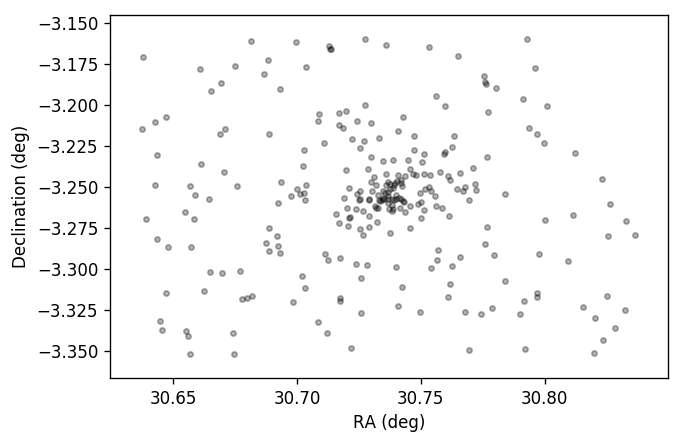

In [81]:
plot(cluster['ra'], cluster['dec'])

Histogram the star counts and smooth on a reasonable scale.

In [284]:
H, xedges, yedges = plt.histogram2d(cluster['ra'], cluster['dec'], range=[[30.6,30.85], [-3.36, -3.15]], bins=(30,30)) 
levels = (0.1, 0.4, 0.7, 1.0, 1.3, 1.45, 1.6, 1.8)
smoothed_hist = gaussian_filter(H, 3.0) # three bin sigma

Compute the extent of the subimage so we can plot the contours.

In [285]:
pixmin = (0, 250)
pixmax = (600, 850)
im = fits.open(os.path.join(home,'DATA/frame-r-007778-1-0522.fits'))
wcs = WCS(im[0].header)
extent = wcs.wcs_pix2world([pixmin[::-1], pixmax[::-1]], 0)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Plot image and contours.  Note that the 2D histogram routine outputs transposed axes. We won't worry about that for now...

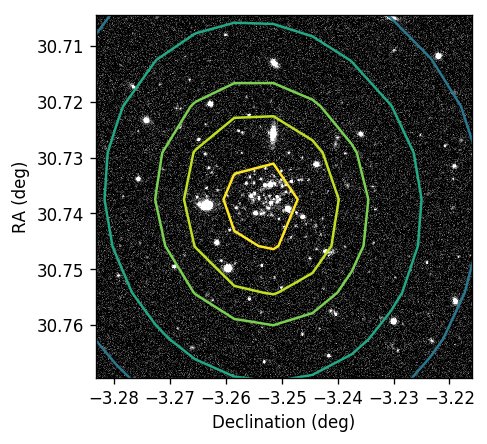

In [286]:
plt.contour(0.5*(yedges[1:] + yedges[:-1]), 0.5*(xedges[1:] + xedges[:-1]), smoothed_hist, levels)
plt.imshow(im[0].data[pixmin[0]:pixmax[0], pixmin[1]:pixmax[1]], vmin=-0.01, vmax=0.2, cmap='gray',
#           extent=(extent[1][0], extent[0][0], extent[0][1], extent[1][1]))
           extent=(extent[0][1], extent[1][1], extent[1][0], extent[0][0]))
plt.xlabel("Declination (deg)")
plt.ylabel("RA (deg)")
plt.show()

Plot the smoothed 2D histogram with the contours overlaid.

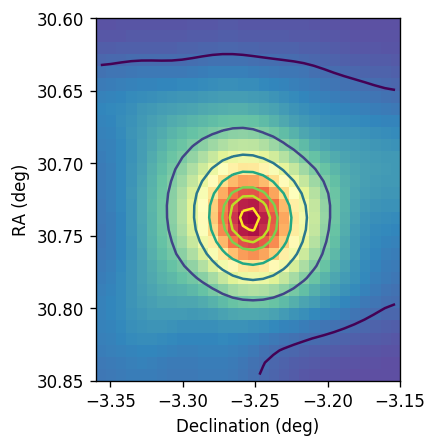

In [287]:
plt.imshow(smoothed_hist, extent=[yedges[0],yedges[-1],xedges[-1],xedges[0]],cmap='Spectral_r')
plt.contour(0.5*(yedges[1:] + yedges[:-1]), 0.5*(xedges[1:] + xedges[:-1]), smoothed_hist, levels)
plt.xlabel("Declination (deg)")
plt.ylabel("RA (deg)")
plt.show()